# Credible set size comparison

while I still don't have working susie, this is kind of meaningless

see if pcqlts have smaller credible sets overall, or if for the same signal (matched lead variant/colocalized signal) the pcqtl credible set is smaller

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress


from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

from scipy.stats import ttest_rel, ranksums

import matplotlib as mpl


In [6]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

In [7]:
# load in the data from all tissues
susie_annotated = load_across_tissues(config, load_susie_annotated, tissue_ids = tissue_ids)
#overlap['num_vars'] = overlap['variant_list'].apply(ast.literal_eval).apply(len)


In [8]:
# drop cross map ones
clusters = load_across_tissues(config, load_clusters_annotated)
susie_annotated = susie_annotated[~susie_annotated['cluster_id'].isin(clusters[clusters['has_cross_map']]['cluster_id'])]

In [9]:
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'lead_variant_id':'first',
                                                                                  'variant_id':list,
                                                                                  'type':'first',
                                                                                  'cluster_id':'first'}).reset_index()

# add pc information to credible sets
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0)
cs_grouped['pc_num'] = cs_grouped['pc_num'].astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
# split first, last, and middle pcs
cs_grouped['pc_order'] = np.where(cs_grouped['pc_num']==0, 'eqtl', 'middle')
cs_grouped.loc[cs_grouped['pc_num'] == cs_grouped['cluster_size'],'pc_order'] = 'last'
cs_grouped.loc[cs_grouped['pc_num'] == 1,'pc_order'] = 'first'
cs_grouped['num_vars'] = cs_grouped['variant_id'].apply(len)

In [10]:
cs_grouped.groupby('pc_order').agg({'num_vars':'mean'})

,num_vars
pc_order,
eqtl,16.327730
first,15.759212
last,19.020080
middle,21.244989


In [11]:
from scipy.stats import mannwhitneyu, ttest_ind

x= cs_grouped[cs_grouped['pc_order']=='eqtl']['num_vars']
y =  cs_grouped[cs_grouped['pc_order']=='first']['num_vars']
print(mannwhitneyu(x,y))
print(ttest_ind(x,y))


MannwhitneyuResult(statistic=84253805.0, pvalue=0.5511108938266769)
Ttest_indResult(statistic=1.0945924485717204, pvalue=0.27370484303950565)


<AxesSubplot: xlabel='num_vars'>

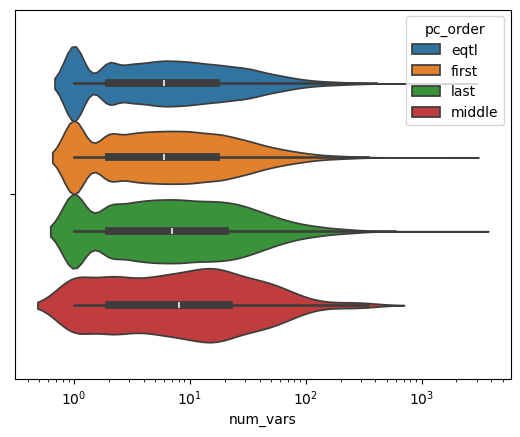

In [12]:
sns.violinplot(cs_grouped, x='num_vars', hue='pc_order', log_scale=True)

In [13]:
# group vep ddf by lead variant
# group by lead variant to prevent varaints from being double counted
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 
                                                                                'type':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'num_vars':list}).reset_index() # you could also do a list of varainces
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e_')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

In [14]:
lead_var_grouped.explode(['num_vars', 'pc_order']).groupby(['exclusive_label', 'pc_order']).agg({'num_vars':'mean'})

num_vars
exclusive_label pc_order           
eqtl_only       eqtl       21.25401
pcqtl_only      first     21.966421
                last      23.462795
                middle    26.638978
shared          eqtl       9.870513
                first     10.738201
                last       9.178571
                middle     8.830882

In [15]:
cs_sizes = lead_var_grouped.explode(['pc_order', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'pc_order']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'pc_order']).agg({'num_vars':min, 'cluster_size':'first', 'num_e_samelead':max}).reset_index()
cs_sizes.groupby('pc_order').agg({'num_vars':'mean'})

,num_vars
pc_order,
eqtl,16.716712
first,15.759212
last,19.022646
middle,21.40699


<AxesSubplot: xlabel='num_vars'>

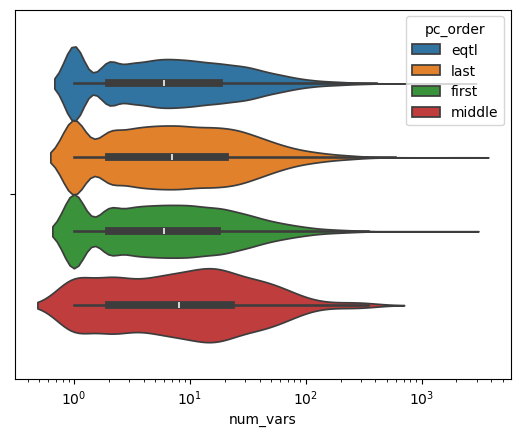

In [16]:
sns.violinplot(cs_sizes, x='num_vars', hue='pc_order', log_scale=True)

In [17]:
x= cs_sizes[cs_sizes['pc_order']=='eqtl']['num_vars'].astype(int)
y = cs_sizes[cs_sizes['pc_order']=='first']['num_vars'].astype(int)
print(mannwhitneyu(x,y))
print(ttest_ind(x,y))

MannwhitneyuResult(statistic=80556279.0, pvalue=0.11089185527792393)
Ttest_indResult(statistic=1.882469724998999, pvalue=0.05978327712858152)


In [18]:
# get the smaller cs for each of the two data types for the shared ones
cs_sizes_shared = lead_var_grouped[lead_var_grouped['exclusive_label']=='shared'].explode(['type', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).agg({'num_vars':min, 'cluster_size':'first', 'num_e_samelead':max, 'num_pc_samelead':max})
cs_sizes_pivot = cs_sizes_shared.pivot_table(index=['lead_variant_id', 'cluster_size', 'num_e_samelead', 'num_pc_samelead'], 
                           columns='type', 
                           values='num_vars', 
                           fill_value=0).reset_index()

<AxesSubplot: xlabel='cs_size_label', ylabel='count'>

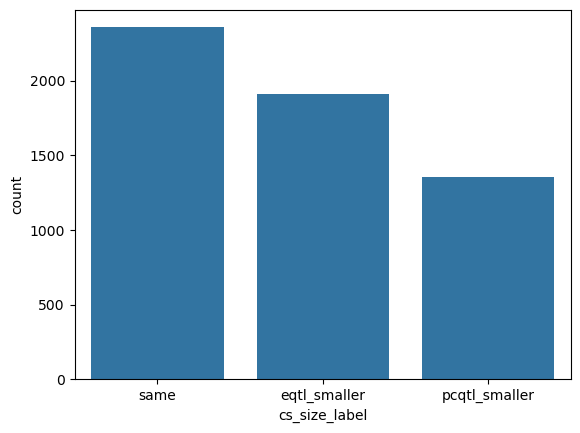

In [19]:
cs_sizes_pivot['cs_size_label'] = np.where(
    cs_sizes_pivot['eqtl'] < cs_sizes_pivot['pcqtl'], 
    'eqtl_smaller', 
    np.where(
        cs_sizes_pivot['eqtl'] > cs_sizes_pivot['pcqtl'], 
        'pcqtl_smaller', 
        'same'
    )
)
sns.countplot(cs_sizes_pivot,  x='cs_size_label')

0.7588841506751954
TtestResult(statistic=-4.780444091999933, pvalue=1.7936020299535818e-06, df=5627)


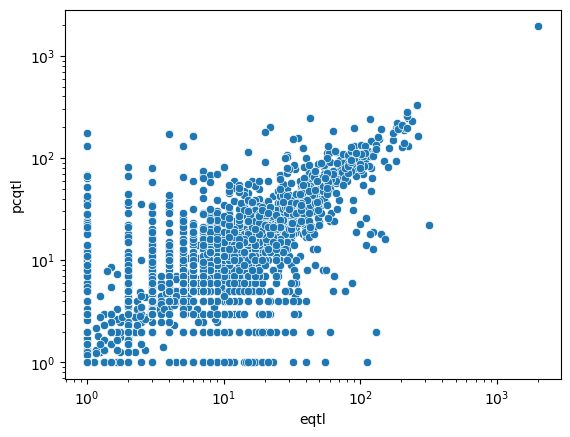

In [20]:
ax = sns.scatterplot(cs_sizes_pivot, x='eqtl', y='pcqtl')
ax.set_xscale('log')
ax.set_yscale('log')
print((cs_sizes_pivot['eqtl'] <= cs_sizes_pivot['pcqtl']).sum()/len(cs_sizes_pivot))
print(ttest_rel(cs_sizes_pivot['eqtl'], cs_sizes_pivot['pcqtl']))

In [21]:
x = cs_sizes_pivot['eqtl']
y = cs_sizes_pivot['pcqtl']
print(np.mean(x))
print(np.mean(y))

print(ttest_rel(x, y))
print(ranksums(x, y))

11.022891120665642
11.877962408652706
TtestResult(statistic=-4.780444091999933, pvalue=1.7936020299535818e-06, df=5627)
RanksumsResult(statistic=-3.3908269801206306, pvalue=0.0006968207686418077)


# look at just multigene clusters

In [22]:
#lead_var_grouped = lead_var_grouped[lead_var_grouped['pc_order'].astype(str).str.contains('first')]

<AxesSubplot: xlabel='cs_size_label', ylabel='count'>

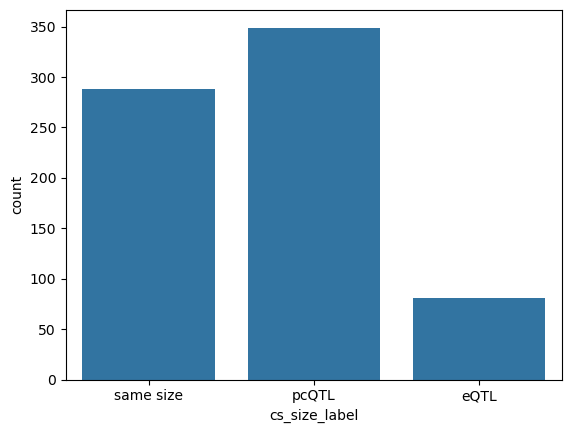

In [23]:
# get the smaller cs for each of the two data types for the shared ones
cs_sizes_shared = lead_var_grouped[(lead_var_grouped['exclusive_label']=='shared')&(lead_var_grouped['num_e_samelead'] > 1)].explode(['type', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).agg({'num_vars':'median', 'cluster_size':'first', 'num_e_samelead':max, 'num_pc_samelead':max})
cs_sizes_pivot = cs_sizes_shared.pivot_table(index=['lead_variant_id', 'cluster_size', 'num_e_samelead', 'num_pc_samelead'], 
                           columns='type', 
                           values='num_vars', 
                           fill_value=0).reset_index()
cs_sizes_pivot['cs_size_label'] = np.where(
    cs_sizes_pivot['eqtl'] < cs_sizes_pivot['pcqtl'], 
    'eQTL', 
    np.where(
        cs_sizes_pivot['eqtl'] > cs_sizes_pivot['pcqtl'], 
        'pcQTL', 
        'same size'
    )
)
sns.countplot(cs_sizes_pivot,  x='cs_size_label')

0.5139275766016713
TtestResult(statistic=6.338469359146869, pvalue=4.1017681974727706e-10, df=717)
RanksumsResult(statistic=4.934009586539695, pvalue=8.055848312466341e-07)


/local/scratch/klawren/slrmtmp.46756152/ipykernel_28817/2652910729.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 250)
/local/scratch/klawren/slrmtmp.46756152/ipykernel_28817/2652910729.py:29: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 250)


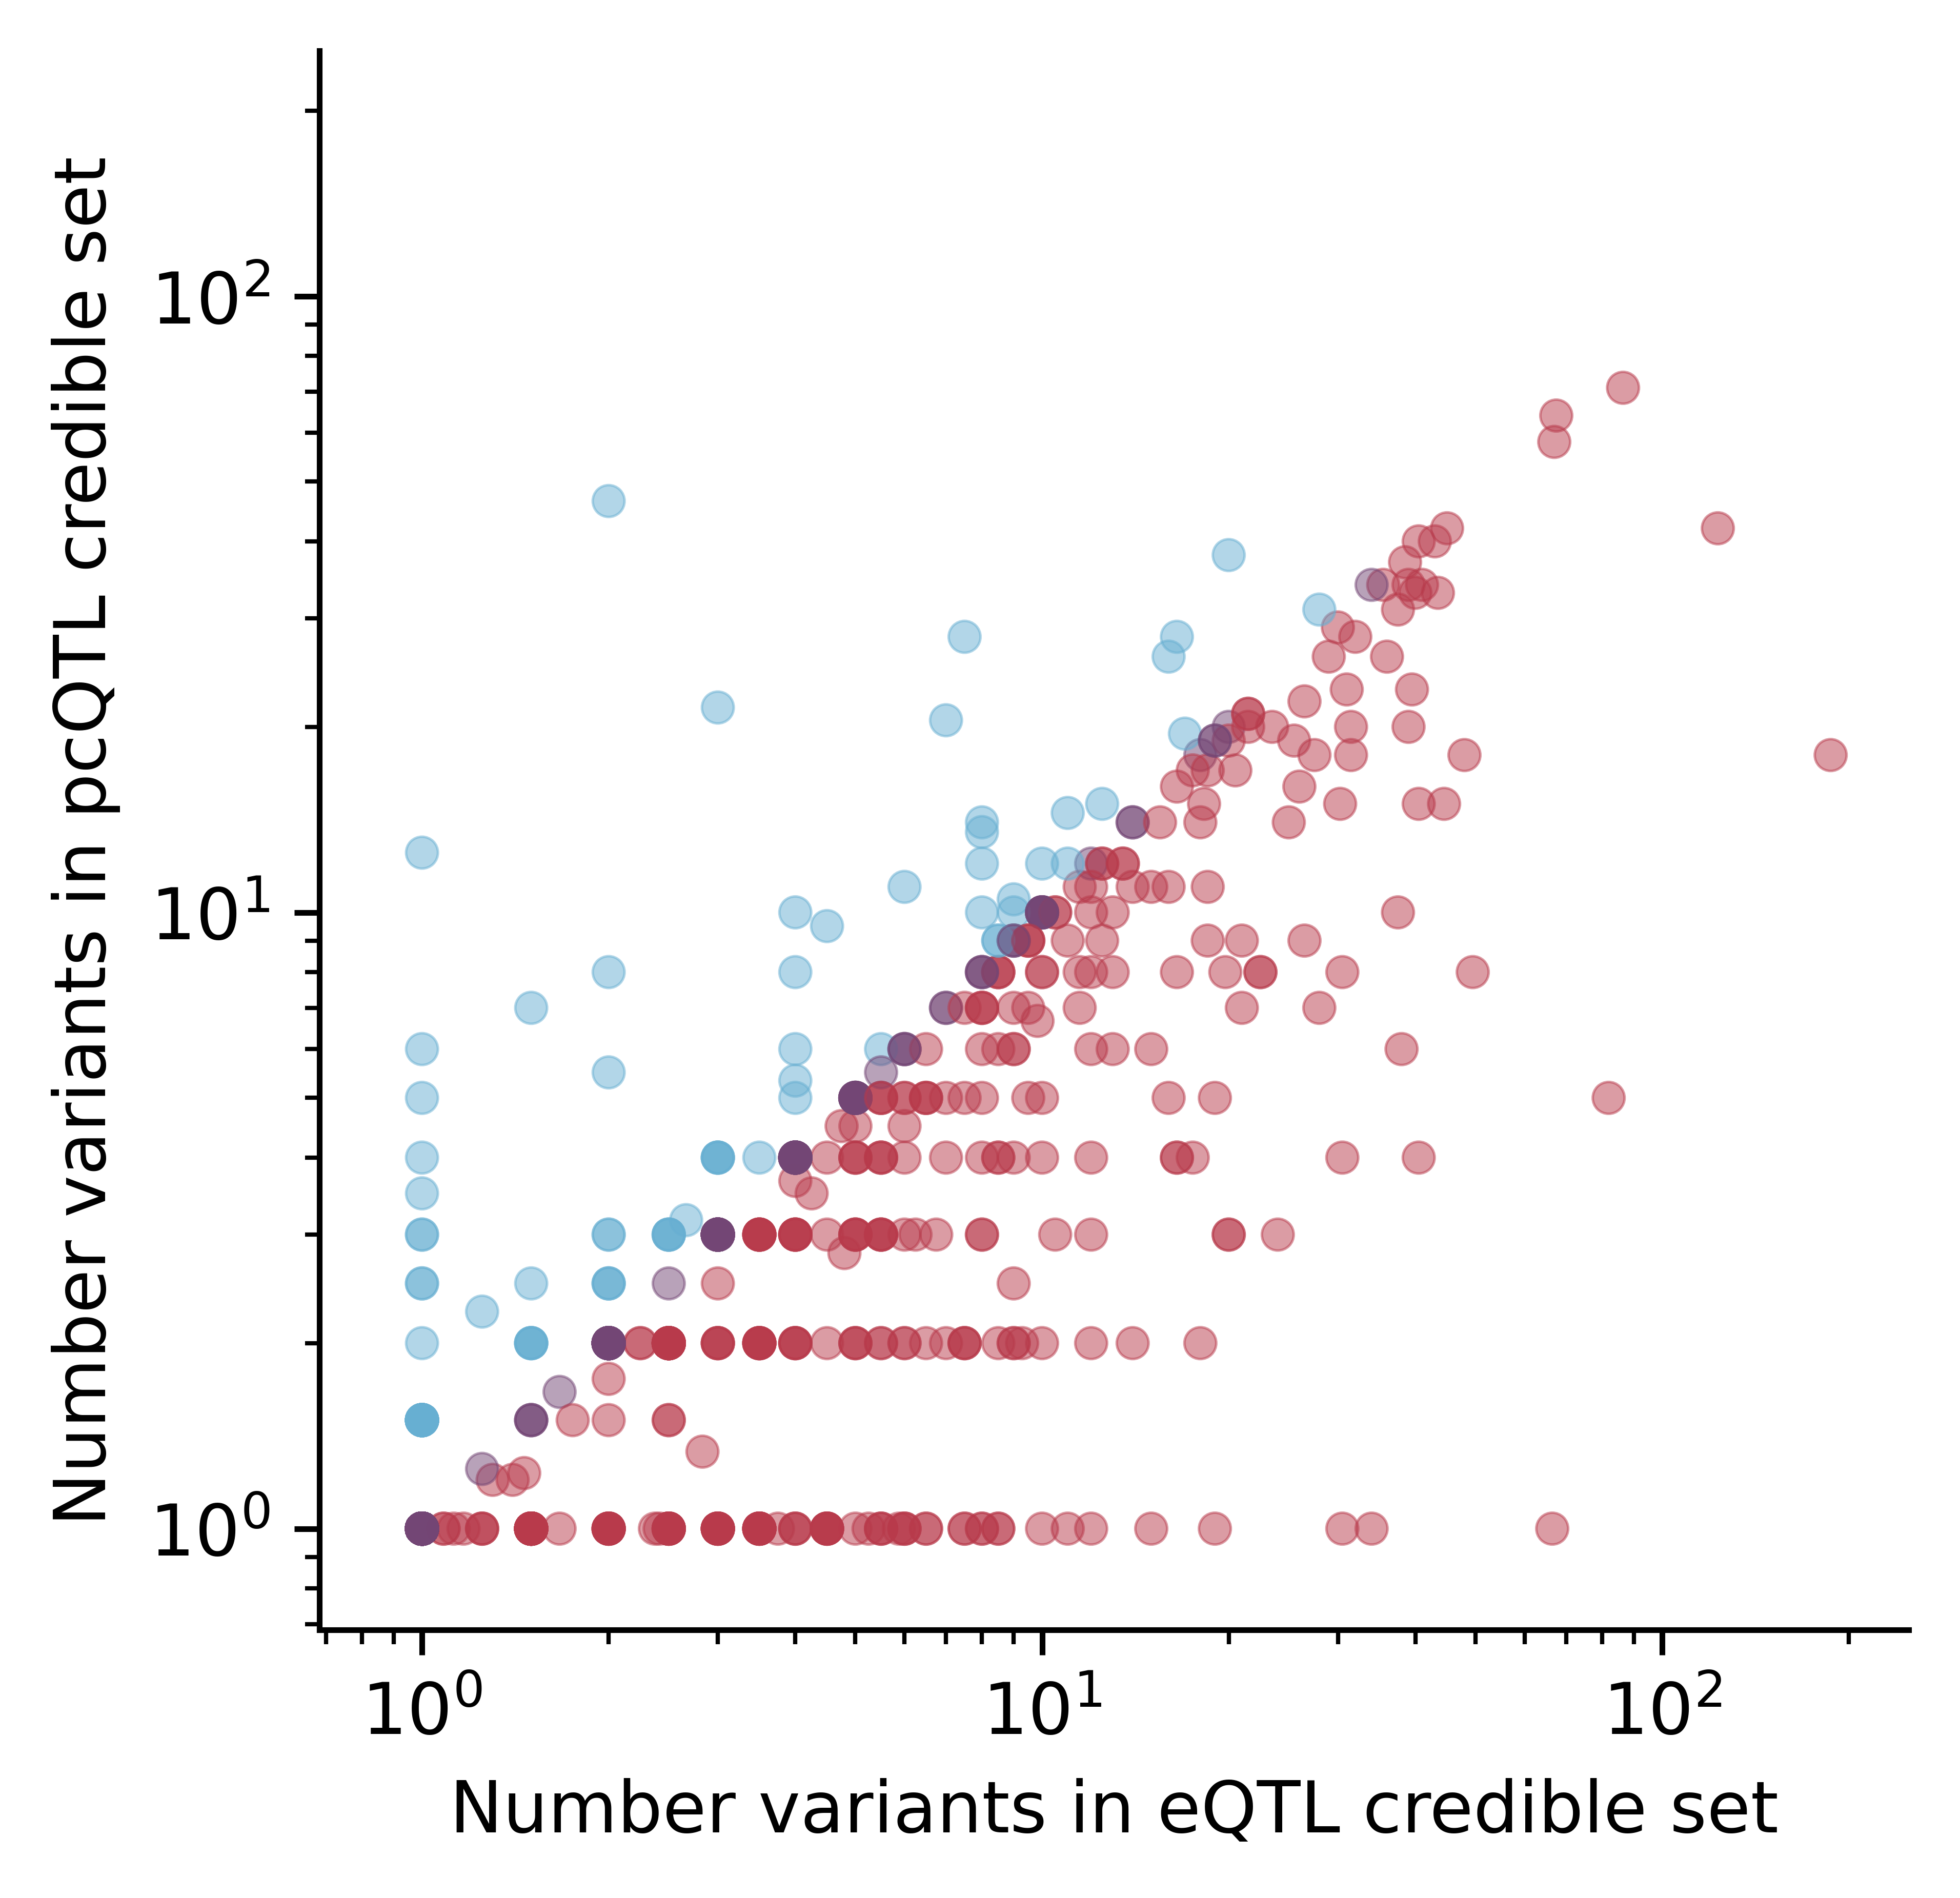

In [27]:
mpl.rcParams['figure.dpi']= 1000

fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(cs_sizes_pivot, x='eqtl', y='pcqtl', hue='cs_size_label', 
                palette={'eQTL':'#67AFD2','pcQTL':'#B83A4B', 'same size':'#734675'}, ax=ax, 
                edgecolor=None, s=20, alpha=.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number variants in pcQTL credible set')
ax.set_xlabel('Number variants in eQTL credible set')

plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('Credible set smaller in:')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print((cs_sizes_pivot['eqtl'] <= cs_sizes_pivot['pcqtl']).sum()/len(cs_sizes_pivot))
x = cs_sizes_pivot['eqtl']
y = cs_sizes_pivot['pcqtl']
print(ttest_rel(x, y))
print(ranksums(x, y))

ax.set_xlim(0, 250)
ax.set_ylim(0, 250)
ax.get_legend().set_visible(False)

mpl.rcParams['figure.dpi']= 100

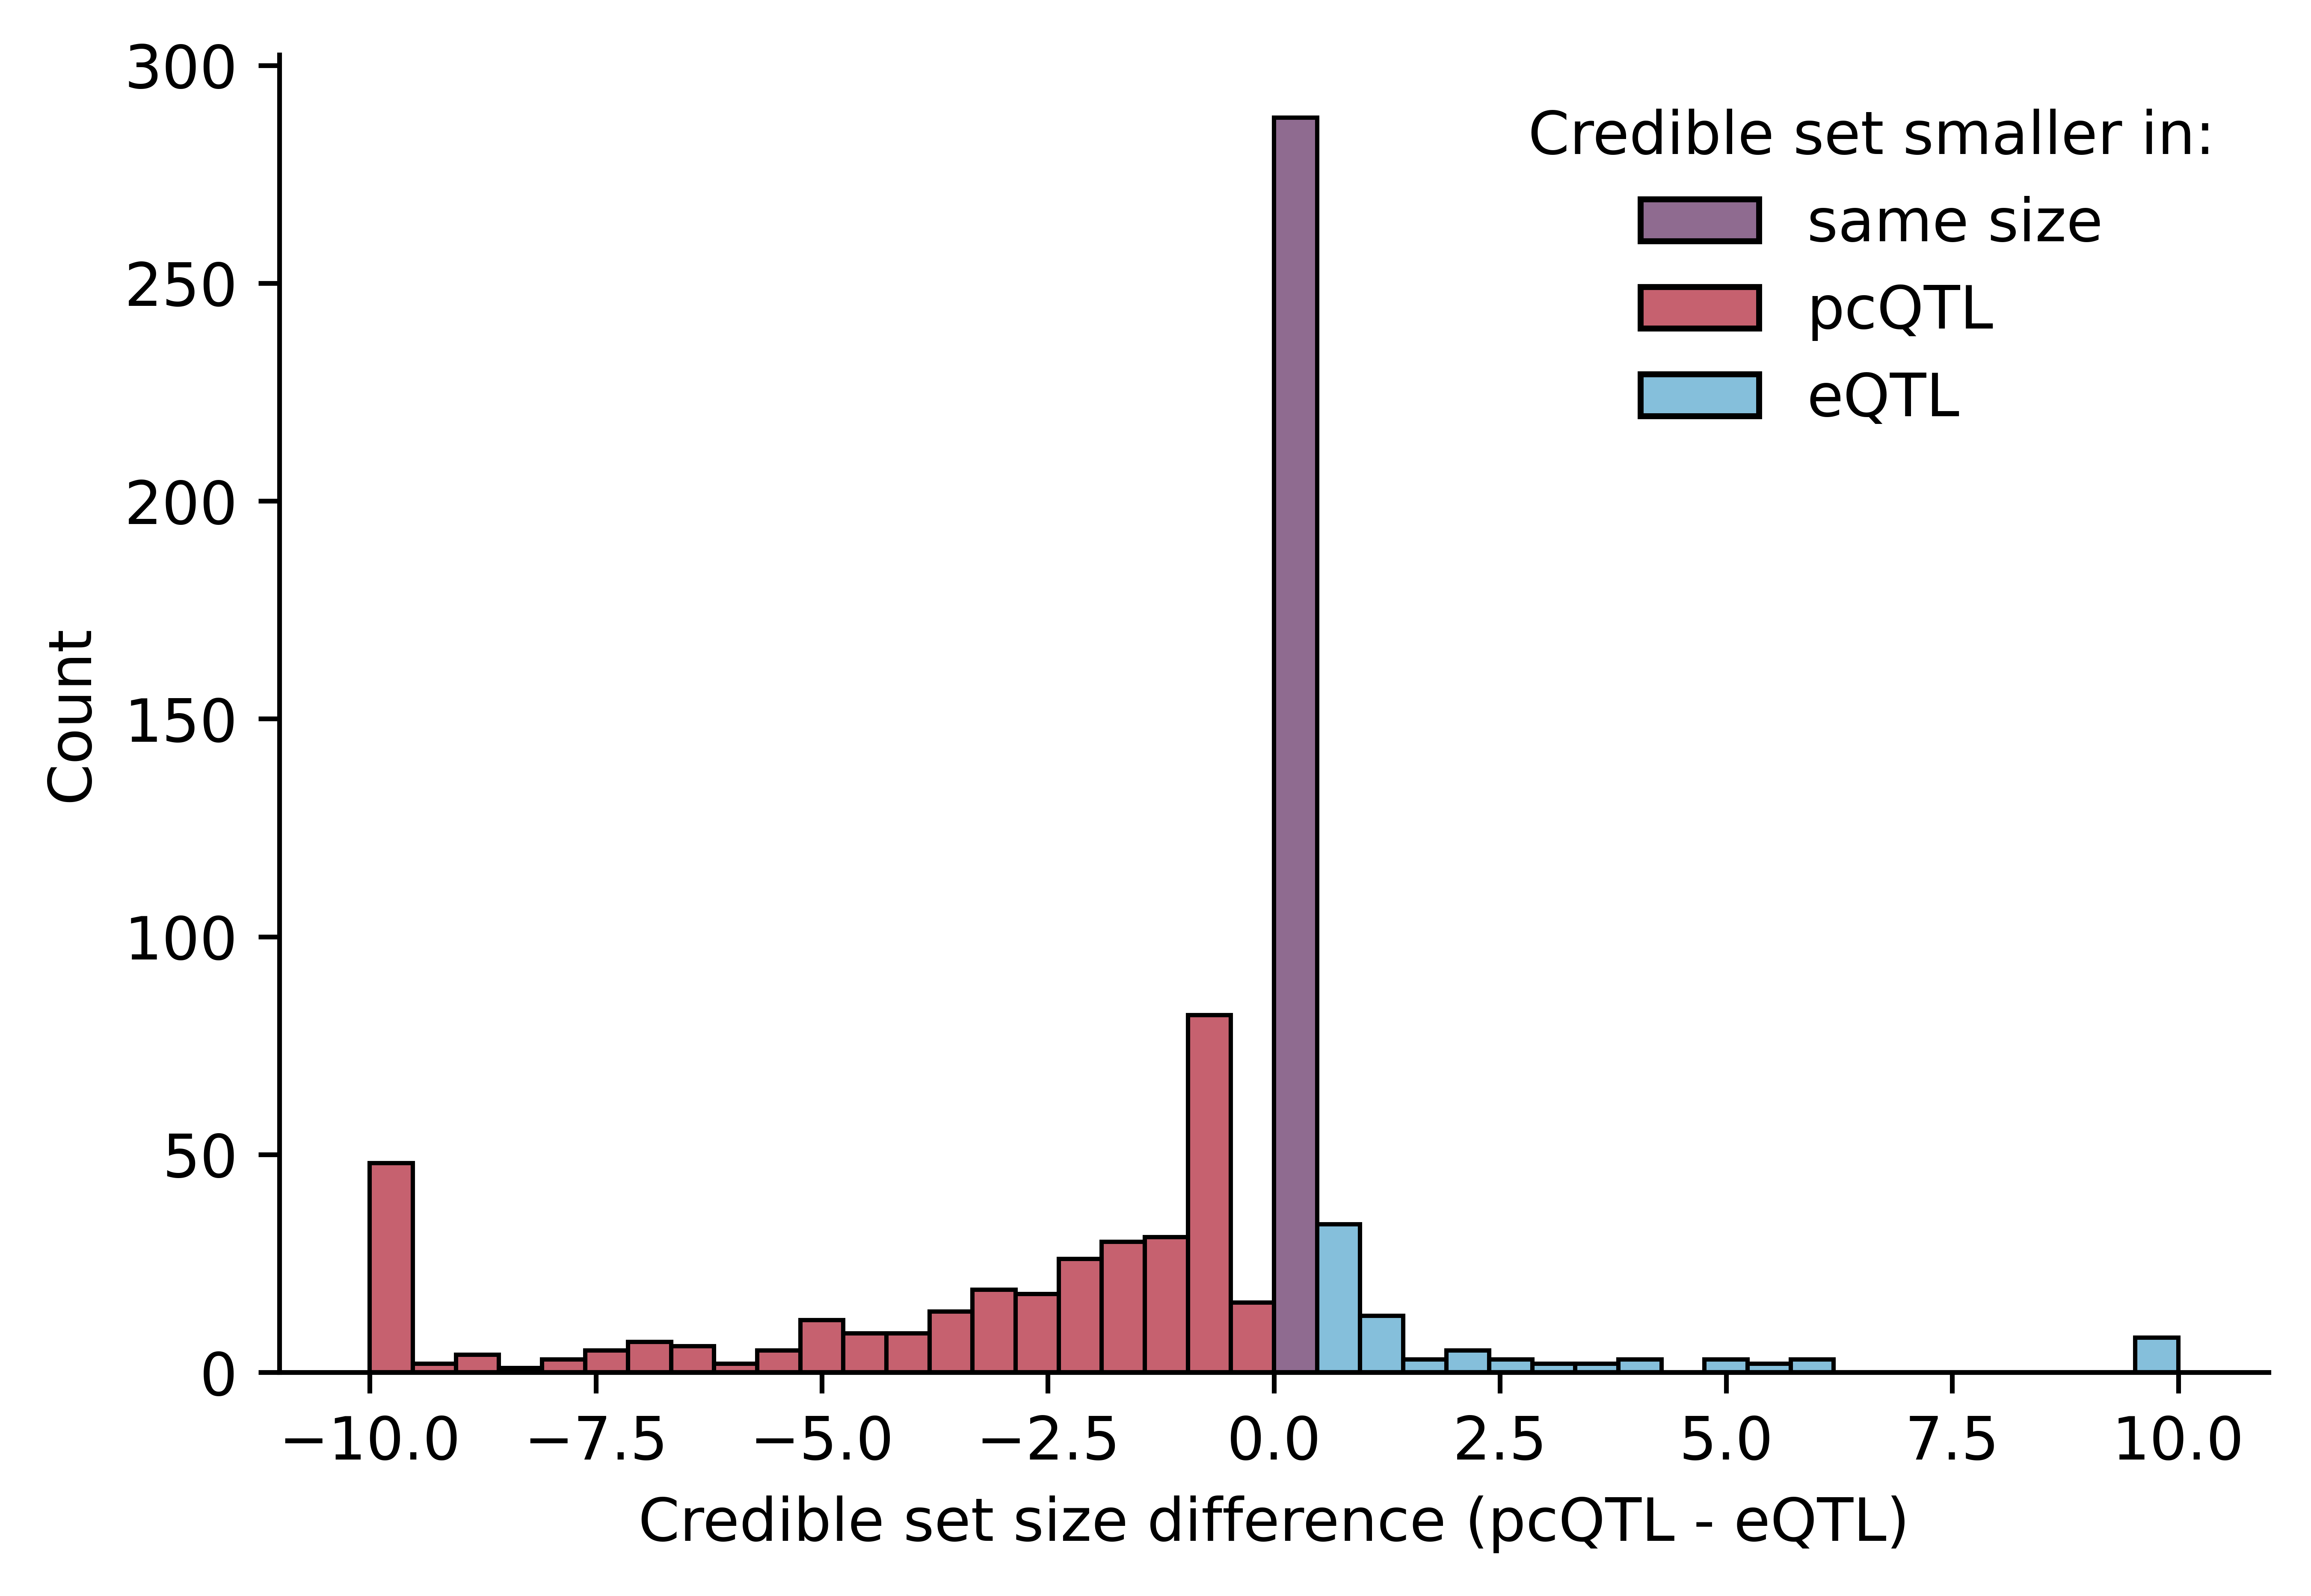

In [35]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1000
cs_sizes_pivot['size_diff'] = cs_sizes_pivot['pcqtl'] - cs_sizes_pivot['eqtl']
cs_sizes_pivot['size_diff'] = cs_sizes_pivot['size_diff'].clip(-10, 10)
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(cs_sizes_pivot, x='size_diff', color='#67AFD2', bins = 42, ax=ax,
             hue='cs_size_label', palette={'eQTL':'#67AFD2','pcQTL':'#B83A4B', 'same size':'#734675'}, alpha=.8)
ax.set_xlabel('Credible set size difference (pcQTL - eQTL)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('Credible set smaller in:')
mpl.rcParams['figure.dpi']= 100



# look at just pc1

In [43]:
# look at just 1st pcs
cs_grouped = cs_grouped[cs_grouped['pc_num'] <2]

# group vep ddf by lead variant
# group by lead variant to prevent varaints from being double counted
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 
                                                                                'type':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'num_vars':list}).reset_index() # you could also do a list of varainces
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e_')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

# get the smaller cs for each of the two data types for the shared ones
cs_sizes = lead_var_grouped[lead_var_grouped['exclusive_label']=='shared'].explode(['type', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).agg({'num_vars':min, 'cluster_size':'first', 'num_e_samelead':max})
cs_sizes_pivot = cs_sizes.pivot_table(index=['lead_variant_id', 'cluster_size', 'num_e_samelead', 'cluster_id'], 
                           columns='type', 
                           values='num_vars', 
                           fill_value=0).reset_index()


<AxesSubplot: xlabel='cs_size_label', ylabel='count'>

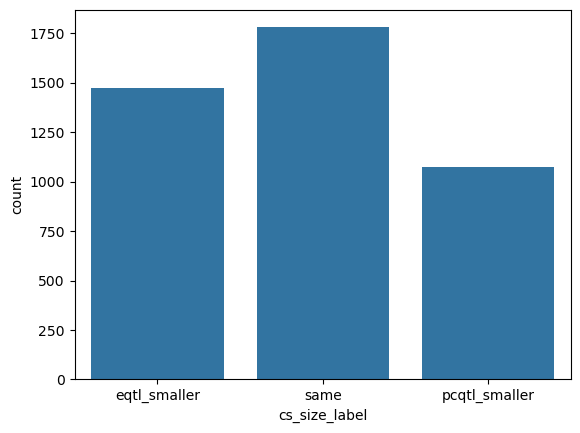

In [22]:
cs_sizes_pivot['cs_size_label'] = np.where(
    cs_sizes_pivot['eqtl'] < cs_sizes_pivot['pcqtl'], 
    'eqtl_smaller', 
    np.where(
        cs_sizes_pivot['eqtl'] > cs_sizes_pivot['pcqtl'], 
        'pcqtl_smaller', 
        'same'
    )
)
sns.countplot(cs_sizes_pivot,  x='cs_size_label')

TtestResult(statistic=-2.6079802655934317, pvalue=0.009139142722163792, df=4324)


NameError: name 'ranksums' is not defined

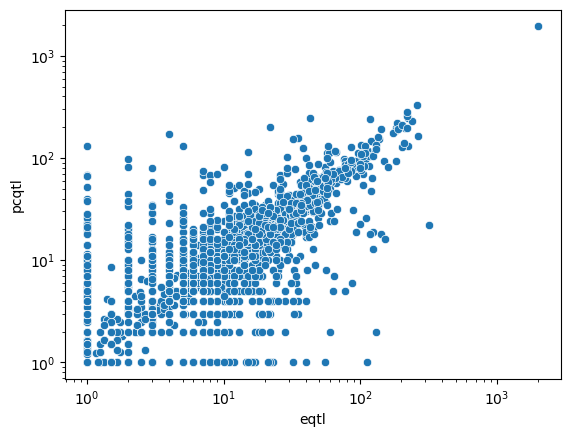

In [23]:
ax = sns.scatterplot(cs_sizes_pivot, x='eqtl', y='pcqtl')
ax.set_xscale('log')
ax.set_yscale('log')
print(ttest_rel(cs_sizes_pivot['eqtl'], cs_sizes_pivot['pcqtl']))
print(ranksums(cs_sizes_pivot['eqtl'], cs_sizes_pivot['pcqtl']))
print((cs_sizes_pivot['eqtl'] <= cs_sizes_pivot['pcqtl']).sum()/len(cs_sizes_pivot))

# high corr clusters?

TtestResult(statistic=-1.5503085412181064, pvalue=0.12137496590444107, df=1029)


NameError: name 'ranksums' is not defined

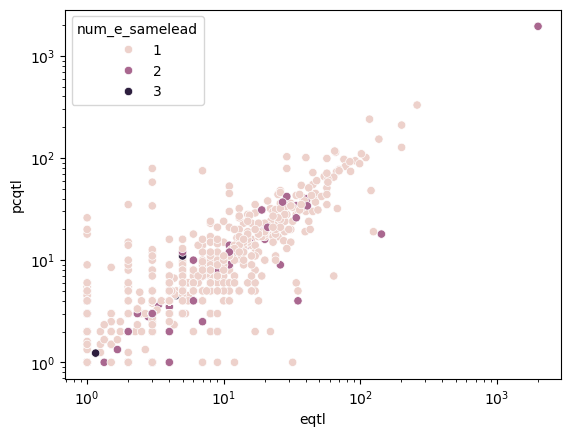

In [24]:
cs_sizes_pivot_high_corr = cs_sizes_pivot[cs_sizes_pivot['cluster_id'].isin(clusters[clusters['abs_cor']>.5]['cluster_id'])]

ax = sns.scatterplot(cs_sizes_pivot_high_corr, x='eqtl', y='pcqtl', hue='num_e_samelead')
ax.set_xscale('log')
ax.set_yscale('log')
print(ttest_rel(cs_sizes_pivot_high_corr['eqtl'], cs_sizes_pivot_high_corr['pcqtl']))
print(ranksums(cs_sizes_pivot_high_corr['eqtl'], cs_sizes_pivot_high_corr['pcqtl']))
print((cs_sizes_pivot_high_corr['eqtl'] < cs_sizes_pivot_high_corr['pcqtl']).sum()/len(cs_sizes_pivot_high_corr))
print((cs_sizes_pivot_high_corr['eqtl'] > cs_sizes_pivot_high_corr['pcqtl']).sum()/len(cs_sizes_pivot_high_corr))